# **Analyse des tendances de prix des ordinateurs portables sur eBay**

### **Introduction**


Notre projet vise à étudier les tendances de consommation des utilisateurs de plateformes de e-commerce, en se concentrant sur les ordinateurs portables sur eBay. Les questions centrales de cette étude sont les suivantes :
- Quels sont les facteurs qui influencent la demande d’un produit et, par conséquent, son prix ?
- Comment estimer le prix d’un ordinateur en fonction de ses caractéristiques ?

Pour y répondre, nous avons distingué deux types de critères :

**Critères objectifs :** RAM, stockage, densité de pixels, condition de l’article.

**Critères subjectifs :** marque, couleur, taille de l’écran.

Nous avons trouvé le choix de la plateforme eBay pertinent dans la mesure où ce sont les utilisateurs qui fixent le prix qu'ils attribuent à leur ordinateur. Cette dynamique permet d’évaluer si les vendeurs sont objectifs dans leur valorisation du produit ou si le prix fixé est cohérent avec les caractéristiques de l’ordinateur. Grâce aux tendances observées, il devient possible de déterminer si ces prix reflètent réellement la valeur des produits.

Afin d’analyser ces influences, nous avons choisi de modéliser la relation entre les caractéristiques des produits et leur prix à l’aide d’une régression linéaire. Cette approche permet de quantifier l’impact de chaque critère sur le prix des ordinateurs portables. Nous pourrons ainsi mieux comprendre comment les utilisateurs déterminent le prix de vente de leurs ordinateurs portables et savoir si certaines variables les influencent plus que d'autres. 


# Sommaire 



## **1. Installation**

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Chargement des données dans le projet**

### **2.1 Données eBay**

En raison du temps de réponse élevé de l’API et du nombre d'appels à l'API limité à 4500 par jour, nous avons préféré exécuter les requêtes en amont et sauvegarder les données dans un fichier CSV. Cette démarche a pour objectif de faciliter l’analyse en évitant les délais d’attente liés à l’API et en permettant d'avoir plus de données. 

Le code permettant de collecter les données est disponible sur le GitHub du projet. Ce script **data.py** situé dans le fichier **src** peut être exécuté en suivant les instructions du README pour l'accès à l'API si de nouvelles données doivent être extraites.

Dans le notebook, nous nous contentons de charger le fichier CSV prégénéré pour effectuer les étapes d’analyse et de nettoyage.

Cette approche permet une expérience plus fluide et garantit la reproductibilité de l’étude sans dépendre des performances de l’API au moment de l’exécution.



### **Récupération des données**

Pour collecter les données nécessaires à notre étude, nous avons utilisé l’API Browse d’eBay. Ce choix s’explique par la richesse des informations disponibles sur cette plateforme et son large catalogue de produits. Cependant, cela a requis plusieurs étapes préparatoires :

1. **Choix d'un segment spécifique :** Pour limiter la variabilité des données, nous avons choisi de nous concentrer sur les ordinateurs portables. Ce segment présente de nombreuses spécificités (RAM, stockage, écran, etc.) qui permettent d’étudier l’impact de chaque critère sur le prix.

2. **Délimitation du marché :** Nous avons choisi de nous focaliser sur le marché français. Cette décision a pour but d’éviter les biais liés à des contextes géopolitiques différents entre les marchés ou à des devises différentes. 

3. **Extraction des données :**
Les informations classiques comme le prix et l’état des articles sont directement accessibles via l’API Browse pour chaque item.
Les caractéristiques plus précises (RAM, marque, stockage, taille de l’écran) sont stockées dans une sous-catégorie nommée localized aspects. Ces informations sont organisées sous forme de dictionnaire (clé/valeur).

4. **Gestion des données manquantes :**
Comme les utilisateurs remplissent eux-mêmes les informations, certaines données sont parfois absentes. 
Plusieurs approches ont été envisagées :
- Exclure les articles avec des données manquantes, en raison du volume important de données disponibles.
- Conserver les articles incomplets pour ne pas réduire excessivement l’échantillon.

Afin de ne pas trop réduire l'échantillon ou de compromettre la fiabilité de l'étude nous avons choisi de conserver les articles ayant obligatoirement les informations suivantes : prix, capacité de stockage, RAM et marque. Toutefois, si des données telles que la taille de l'écran, la résolution ou encore la date de publication ne sont pas présentes il ne nous semblait pas pertinent d'enlever ces ordinateurs portables puisque cela ne compromet pas le résultat de notre étude et nous permet d'avoir un échantillon plus important.

In [3]:
from src.utils import load_data

ordi_csv = "data3.csv"
df = load_data(ordi_csv)

### **2.2 Données issues de scrapping**

## **3. Nettoyage des données**

Comme évoqué plus tôt, la particularité des données récoltées est qu'elles ont été entrées par les vendeurs eux-mêmes via la plateforme. Ainsi, si le nom de la catégorie (ex: 'RAM', 'Stockage') est le même pour chaque produit, les informations contenues dans chaque colonne différent dans leur format. Par défaut, toutes les données sont de type "object" ce qui ne les rend pas exploitable directement pour nous. Le travail de nettoyage est ainsi essentiel afin d'avancer sur notre projet.  

1) **Nettoyage des données chiffrées**

Pour cela, nous avons créé une fonction **extract_float_from_object** au sein du fichier **utils.py** qui permet d'extraire un nombre de type float à partir d'une chaîne de caractère. Nous pouvons appliquer cette fonction directement pour la catégorie 'Taille écran'.

In [4]:
from src.utils import extract_float_from_object, extract_storage

df['Taille écran'] = df['Taille écran'].apply(extract_float_from_object)

Pour gérer les catégories liées au stockage dont les données étaient soit rentrées en Go, soit en To, nous avons créé une seconde fonction dérivée de la première, mais qui effectue la conversion en Go pour les données entrées en To, selon la formule **1To = 1024Go**.

In [5]:
df['RAM'] = df['RAM'].apply(extract_storage)
df['Stockage'] = df['Stockage'].apply(extract_storage)

Ensuite, pour gérer la colonne résolution dont le format est le suivant : **Largeur x Hauteur'**, nous avons choisi de combiner cette information avec la taille de l'écran pour établir une mesure comparable entre tous les ordinateurs du data frame : la densité de pixels (PPI).

$$
Densité\ de\ pixels = \frac{\sqrt{\text{largeur}^2 + \text{hauteur}^2}}{\text{taille de l'écran en pouces}}
$$

On commence par extraire la largeur et la hauteur dans deux nouvelles colonnes, et on utilise ensuite la formule ci-dessus pour créer la colonne **PPI** que l'on conservera.

In [6]:
#Extraction de la résolution dans deux nouvelles colonnes
df[['Largeur', 'Hauteur']] = df['Résolution'].str.extract(r'(\d+)[\s]*[xX][\s]*(\d+)', expand=True)
df[['Largeur', 'Hauteur']] = df[['Largeur', 'Hauteur']].apply(pd.to_numeric, errors='coerce')

#Calcul du PPI
df['Taille écran'] = df['Taille écran'].apply(extract_float_from_object)
df[['Largeur', 'Hauteur', 'Taille écran']] = df[['Largeur', 'Hauteur', 'Taille écran']].replace(0, np.nan)
# On calcule le PPI uniquement pour les lignes où toutes les valeurs nécessaires sont présentes
mask = df[['Largeur', 'Hauteur', 'Taille écran']].notnull().all(axis=1)
df.loc[mask, 'PPI'] = np.round(np.sqrt(df.loc[mask, 'Largeur']**2 + df.loc[mask, 'Hauteur']**2) / df.loc[mask, 'Taille écran'])

2. **Nettoyage des données temporelles**

Cela concerne uniquement la colonne **Date de publication**. Ici, le format est idéal car c'est une information qui nous est fournie directement par eBay. On utilise alors la fonction intégrée à pandas **pd.to_datetime()**

In [7]:
df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')

3. **Nettoyage des données textuelles**

Cela concerne les colonnes **Condition**, **Marque** et **Couleur**. Ici, l'enjeu est d'uniformiser les données afin de rassembler toutes les données identiques de fait mais rentrées différemment par les utilisateurs. 

In [8]:
#Normalisation des couleurs
def normalize_color(color):
    if isinstance(color, str):
        color = color.lower()
        if 'gris' in color or 'silver' in color or 'argent' in color or 'argenté' in color or 'grey' in color and 'graphite' in color:
            return 'gris'
        elif 'noir' in color or 'black' in color:
            return 'noir'
        elif 'blanc' in color or 'white' in color:
            return 'blanc'
        elif 'bleu' in color or 'midnight' in color or 'blue' in color:
            return 'bleu'
        elif 'rouge' in color or 'red' in color:
            return 'rouge'
        elif 'vert' in color or 'green' in color:
            return 'vert'
        elif 'jaune' in color or 'yellow' in color:
            return 'jaune'
        elif 'rose' in color or 'pink' in color:
            return 'rose'
        elif 'marron' in color or 'brown' in color:
            return 'marron'
        elif 'violet' in color or 'purple' in color:
            return 'violet'
    return "autre"

df['Couleur'] = df['Couleur'].apply(normalize_color)

#Normalisation des conditions 
def convertir_condition(condition):
    """ 
    Crée une classification des conditions des produits du meilleur au pire
    """
    if "Neuf" in condition:
        return "Neuf"
    elif "Ouvert (jamais utilisé)" in condition:
        return "Ouvert"
    elif 'Parfait état - Reconditionné' in condition: 
        return "Parfait état"
    elif 'Très bon état - Reconditionné' in condition:
        return "Très bon état"
    elif 'État correct - Reconditionné' in condition:
        return "État correct"
    elif 'Occasion' in condition: 
        return "Occasion"
    
df['Condition'] = df['Condition'].apply(convertir_condition)

#Normalisation des marques
def format_marque(marque):
    if isinstance(marque, str):
        marque = marque.lower()
        if any(substring in marque for substring in ['carte graphique', 'nvidia']):
            return np.nan #Ici, on élimine également les lignes qui ne correspondent 
                          #pas à des ordinateurs portables, rentrées par erreur
        elif 'apple' in marque or 'macbook' in marque:
            return 'Apple'
        elif 'dell' in marque or 'del' in marque:
            return 'Dell'
        elif 'hp' in marque:
            return 'HP'
        elif 'lenovo' in marque:
            return 'Lenovo'
        elif 'asus' in marque:
            return 'Asus'
        elif 'acer' in marque:
            return 'Acer'
        elif 'samsung' in marque:
            return 'Samsung'
        elif 'sony' in marque:
            return 'Sony'
        elif 'toshiba' in marque:
            return 'Toshiba'
        elif 'huawei' in marque:
            return 'Huawei'
        elif 'msi' in marque:
            return 'MSI'
        elif 'panasonic' in marque:
            return 'Panasonic'
        elif 'microsoft' in marque:
            return 'Microsoft'
        elif 'lg' in marque:
            return 'LG'
        elif 'google' in marque:
            return 'Google'
        elif 'alienware' in marque:
            return 'Alienware'
        elif 'razer' in marque:
            return 'Razer'
        elif 'gigabyte' in marque:
            return 'Gigabyte'
        elif 'clevo' in marque:
            return 'Clevo'
        elif 'fujitsu' in marque:
            return 'Fujitsu'
        elif 'medion' in marque:
            return 'Medion'
        elif 'xmg' in marque:
            return 'XMG'
        elif 'chuwi' in marque:
            return 'Chuwi'
        elif 'jumper' in marque:
            return 'Jumper'
        elif 'teclast' in marque:
            return 'Teclast'
        elif 'voyo' in marque:
            return 'Voyo'
        elif 'bmax' in marque:
            return 'BMAX'
        elif 'one-netbook' in marque:
            return 'One-Netbook'
        elif 'gpd' in marque:
            return 'GPD'
        elif 'tuxedo' in marque:
            return 'Tuxedo'
        elif 'system76' in marque:
            return 'System76'
        elif 'purism' in marque:
            return 'Purism'
        elif 'pine64' in marque:
            return 'Pine64'
        elif 'minisforum' in marque:
            return 'Minisforum'
        elif 'azulle' in marque:
            return 'Azulle'
        elif 'beelink' in marque:
            return 'Beelink'
        elif 'meego' in marque:
            return 'Meego'
        elif 'vorke' in marque:
            return 'Vorke'
        elif 'trigkey' in marque:
            return 'Trigkey'
        elif 'acepc' in marque:
            return 'ACEPC'
        elif 'awow' in marque:
            return 'AWOW'
        elif 'niuniutab' in marque:
            return 'Niuniutab'
        else:
            return np.nan
    return np.nan


df['Marque'] = df['Marque'].apply(format_marque)
df = df.dropna(subset=['Marque'])


On se débarasse des colonnes qui nous seront inutiles pour la suite


In [9]:
df = df.drop(['Largeur', 'Hauteur', 'Résolution'], axis=1)
#la colonne résolution est remplacée par la colonne PPI qui compile taille de l'écran et résolution

Pour obtenir notre data frame final, il reste encore à gérer les valeurs aberrantes qui sont assez fréquentes du fait des erreurs ou mauvais choix des utilisateurs eBay.

4. **Gestion des valeurs aberrantes**

Un bon outil pour repérer les valeurs aberrantes est la boîte à moustache qui nous donne une vision claire de la répartition des données pour chaque catégorie. On peut la générer pour chaque colonne grâce à la fonction suivante:

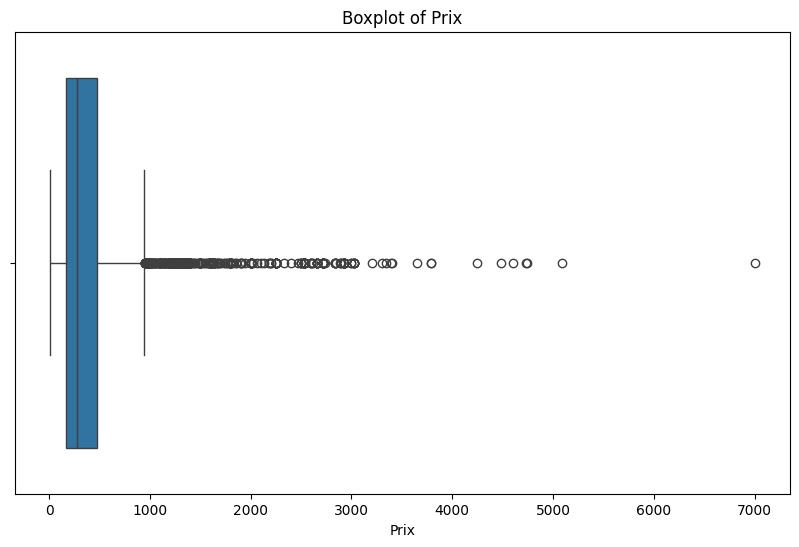

In [10]:
def boxplot(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

boxplot(df, 'Prix')
#boxplot(df, 'Stockage')
#boxplot(df, 'RAM')
#boxplot(df, 'PPI')
#boxplot(df, 'Taille écran')

Grâce à ces boites à moustache ainsi qu'un peu de logique, on établit une plage cohérente pour chaque colonne. Toute donnée à l'extérieur de ces plages est considérée comme "aberrante" et est gérée en fonction. 

**Caractéristiques des plages** :

- **Plage des prix** : $[50\ € ;\ 3000\ €]$
- **Plage de la densité de pixels** : $[80\ \text{PPI} ;\ 300\ \text{PPI}]$
- **Plage de la capacité de stockage** : $[32\ \text{Go} ;\ 4000\ \text{Go}]$
- **Plage de la capacité de RAM** : $[2\ \text{Go} ;\ 64\ \text{Go}]$
- **Plage de la taille d’écran** : $[6'' ;\ 20'']$


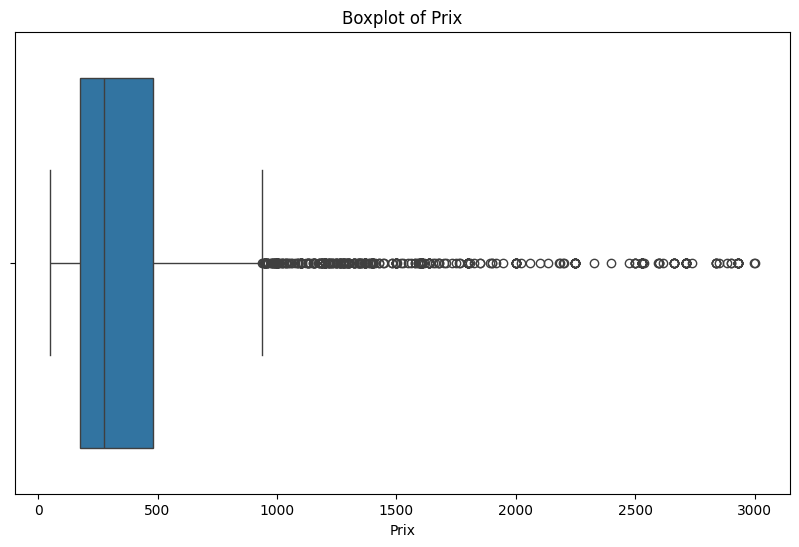

In [11]:
df = df[(df['Prix'] >= 50) & (df['Prix'] <= 3000)]  
df.loc[(df['PPI'] > 300) | (df['PPI'] < 80), 'PPI'] = np.nan
# énormément de gens se trompent en mettant la même valeur pour la RAM et le stockage
df.loc[(df['Stockage'] < 32) | (df['Stockage'] > 4000), 'Stockage'] = np.nan  
df.loc[(df['RAM'] < 2) | (df['RAM'] > 64), 'RAM'] = np.nan  
df.loc[(df['Taille écran'] < 6) | (df['Taille écran'] > 20), 'Taille écran'] = np.nan  

boxplot(df, 'Prix')


Etant donné que l'on cherche à estimer le prix, on a décidé de supprimer les lignes où les prix étaient aberrants. Pour les autres variables, on a décidé de les remplacer par des **NaN** pour les exclure de la visualisation sans se priver de l'information que nous apporte les autres données de cet ordinateur.

Notre data frame est à présent nettoyé, nous allons pouvoir commencer à l'analyser.

In [12]:
df.head(10)

,ID,Prix,Condition,RAM,Stockage,Marque,Couleur,Taille écran,Date de publication,Rang,PPI
0,v1|176737201854|0,1680.0,Occasion,16.0,NaN,Asus,autre,13.4,2024-12-15 17:33:06+00:00,5.0,NaN
1,v1|375863586836|0,550.0,Occasion,8.0,256.0,Apple,gris,13.0,2024-12-13 08:42:48+00:00,1.0,232.0
2,v1|146269671817|0,120.0,Occasion,6.0,700.0,Asus,rouge,15.6,2024-12-15 11:51:11+00:00,5.0,NaN
3,v1|196898961056|0,89.9,Occasion,8.0,480.0,HP,autre,17.3,2024-12-17 16:37:02+00:00,3.0,NaN
4,v1|365291982473|0,1300.0,Occasion,16.0,256.0,Dell,noir,13.0,2024-12-17 16:57:08+00:00,7.0,169.0
5,v1|235873614482|0,75.0,Occasion,4.0,64.0,HP,blanc,14.1,2024-12-16 18:07:16+00:00,3.0,111.0
6,v1|226501515887|0,230.0,Occasion,8.0,128.0,Asus,autre,14.0,2024-12-17 21:45:30+00:00,5.0,NaN
7,v1|326373954761|0,340.0,Ouvert,16.0,256.0,Dell,gris,14.0,2024-12-16 19:12:19+00:00,7.0,157.0
9,v1|196734278702|0,169.0,Très bon état,8.0,620.0,Panasonic,noir,12.0,2024-10-19 09:22:26+00:00,6.0,NaN
10,v1|286214085403|0,80.0,Occasion,8.0,256.0,Lenovo,noir,14.0,2024-12-13 23:59:37+00:00,7.0,NaN


## **4. Visualisation**

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4036 entries, 0 to 4299
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   4036 non-null   object             
 1   Prix                 4036 non-null   float64            
 2   Condition            4033 non-null   object             
 3   RAM                  3805 non-null   float64            
 4   Stockage             3695 non-null   float64            
 5   Marque               4036 non-null   object             
 6   Couleur              4036 non-null   object             
 7   Taille écran         3707 non-null   float64            
 8   Date de publication  4036 non-null   datetime64[ns, UTC]
 9   Rang                 3189 non-null   float64            
 10  PPI                  2110 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(4)
memory usage: 378.4+ KB


On remarque que beaucoup de valeurs sont manquantes pour la densité de pixels. Nous considérons cependant que le nombre d'observations demeure assez élevé pour identifier son effet sur les prix. 
De manière générale, nous faisons l'hypothèse que les valeurs manquantes ne reflète pas un biais car elles sont issues des informations entrées par les vendeurs indépendants qui peuvent vendre n'importe quel type d'ordinateurs. 

In [20]:
df.describe()

,Prix,RAM,Stockage,Taille écran,Rang,PPI
count,4036.000000,3805.000000,3695.000000,3707.000000,3189.000000,2110.000000
mean,430.723840,11.170039,409.686084,14.289161,4.182189,147.698104
std,464.514841,8.393969,293.168790,1.618012,2.518386,40.568522
min,50.000000,2.000000,32.000000,6.000000,0.000000,82.000000
25%,175.000000,8.000000,256.000000,13.300000,2.000000,112.000000
50%,277.150000,8.000000,256.000000,14.000000,5.000000,141.000000
75%,479.990000,16.000000,512.000000,15.600000,7.000000,157.000000
max,3000.000000,64.000000,2048.000000,20.000000,8.000000,294.000000


Est-ce qu'on remplace les valeurs manquantes (par la médiane ou autres selon pertinence) maintenant ou après ??

Nous pouvons pour commencer analyser les distributions de prix. Nous faisons pour cela appel aux fonctions situées dans le fichier **analyse.py**

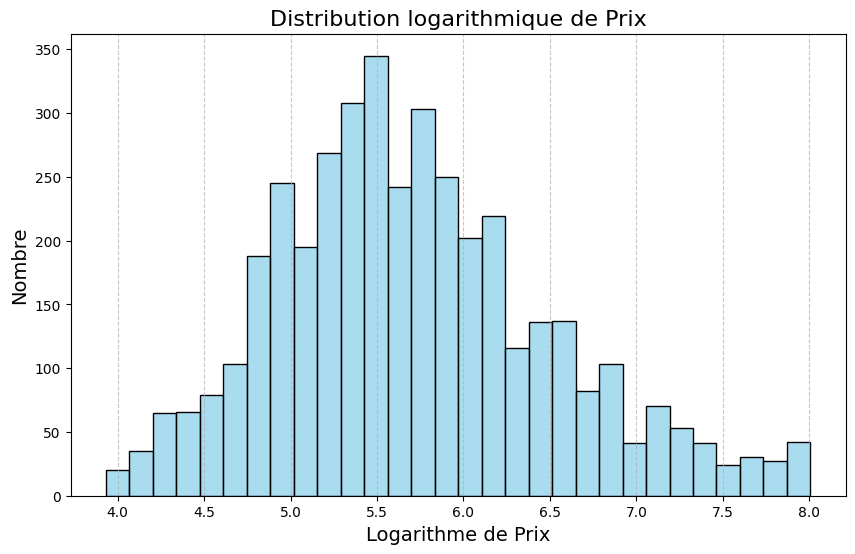

In [21]:
from src.graph import plot_log_distribution
plot_log_distribution(df, 'Prix')

Le graphique représente la distribution logarithmique des prix des ordinateurs portables, permettant une meilleure visualisation des données initialement asymétriques. La distribution semble montrer une forme unimodale avec un seul pic autour de 5.5 en logarithme. 
Cette concentration autour de 5.5 suggère qu'une grande partie des ordinateurs portables se situe dans une gamme de prix cohérente après transformation. 
Toutefois la présence d'une queue gauche ressérée suggère qu'il y a peu d'ordinateurs dans des gammes de prix très basses tandis que la queue droite étendue pourrait suggérer la présence de modèles haut de gamme tirant les prix vers le haut. 

Maintenant que nous savons que les prix sont assez cohérents et concentrés autour d'une valeur nous pouvons essayer de déterminer l'influence des différents facteurs sur le prix.

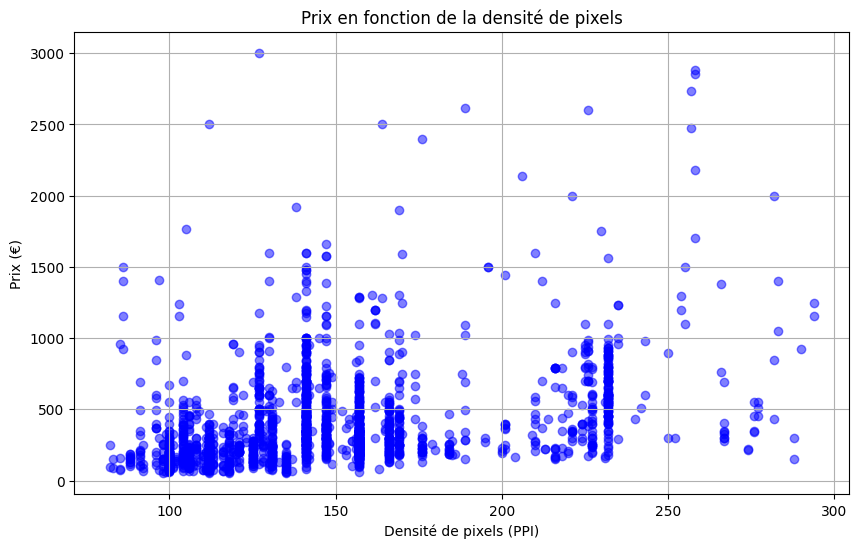

In [22]:
from src.graph import plot_price
plot_price(df)

La visualisation montre une corrélation positive modérée entre le prix et le PPI. Cela signifie que les ordinateurs portables avec des écrans de meilleure qualité tendent à coûter plus cher. Cette relation n'est toutefois pas évidente au vu du graphique. Nous ne pouvons pas tracer une droite de corrélation précise sur le graphique. Ainsi la densité de pixels ne semble pas être un facteur trop déterminant du prix. 

Attardons nous maintenant sur la qualité des ordinateurs : 

In [23]:
from src.graph import etat
etat(df)

ImportError: cannot import name 'etat' from 'src.graph' (/Users/noelinecasteil/Desktop/Projet_evaluation_prix_eBay/src/graph.py)

## **5. Modélisation**